<a href="https://colab.research.google.com/github/Guiillotine/SoftwareEngineering/blob/volyncevich/Twitter_Model_1Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Одномерная сверточная модель

Импорт библиотек:

In [ ]:
# Cтандартные библиотеки для работы с массивами и табличными данными
import numpy as np
import pandas as pd
# Для работы с регулярными выражениями
import re
# Для визуализации графиков
import matplotlib.pyplot as plt
# Библиотека для обработки естественного языка, включая работу со стоп-словами и лемматизацию
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Библиотека для построения и тренировки модели с использованием глубокого обучения, включая слои нейронной сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Библиотека для разделения данных на обучающую и тестовую выборки, балансировки классов и вычисления метрик
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

Загрузка ресурсов NLTK:

In [ ]:
# Cкачивание необходимых данных для лемматизации и работы со стоп-словами
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Инициализация инструментов для обработки текста:

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

## Загрузка данных

Загрузка нужных для обучения файлов:

In [ ]:
# Функция для чтения CSV-файлов по ссылке. В URL заменяется часть для получения прямого доступа
def readCsvByLink(url):
  url='https://drive.google.com/uc?id=' + url.split('/')[-2] # Извлекаем id файла
  return pd.read_csv(url)

In [ ]:
# Загрузка обучающего и тестового наборов данных из Google Drive
train_df = readCsvByLink("https://drive.google.com/file/d/10_zwLLKTklGvnZpTXJYWouPmGmVt5Je_/view?usp=drive_link")
test_df = readCsvByLink("https://drive.google.com/file/d/17epsBjuyGCkBbNMtyyOo6DJTfeTW-am_/view?usp=drive_link")

In [ ]:
f"Постов для обучения: {train_df.shape[0]}, для тестирования: {str(test_df.shape[0])}"

'Постов для обучения: 7613, для тестирования: 3263'

In [ ]:
train_df[["text", "target"]]

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [ ]:
test_df["text"]

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan
...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,Storm in RI worse than last hurricane. My city...
3260,Green Line derailment in Chicago http://t.co/U...
3261,MEG issues Hazardous Weather Outlook (HWO) htt...


## Очистка данных

Функция очищает текст от всего, что не является буквами (с помощью регулярных выражений):

In [ ]:
# Функция приводит текст к нижнему регистру, лемматизирует каждое слово, удаляя стоп-слова и слова длиной менее 3 символов
def clean_text(texts):
    cleaned_texts = []
    for text in texts:
        if not isinstance(text, str):
            text = ""
        text = re.sub(r'[^a-zA-Z]', ' ', text)  # Удаление символов
        text = text.lower()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
        cleaned_texts.append(' '.join(words))
    return cleaned_texts

Применение функции к столбцам:

In [ ]:
train_texts = clean_text(train_df['text'])
test_texts = clean_text(test_df['text'])

## Подготовка данных

Параметры токенизации:

In [ ]:
num_words = 10000  # Максимальное количество слов
max_post_len = 200  # Максимальная длина текстов

Токенизация текста:

In [ ]:
tokenizer = Tokenizer(num_words=num_words) # Создается токенизатор, который преобразует текст в последовательности индексов слов
tokenizer.fit_on_texts(train_texts) # Обучение токенизатора на текстах обучающего набора данных

Пример:

In [ ]:
list(tokenizer.word_index.items())[:20] # 20 наиболее часто встерчающихся слов и соответствующие им номера

[('http', 1),
 ('fire', 2),
 ('like', 3),
 ('amp', 4),
 ('get', 5),
 ('new', 6),
 ('via', 7),
 ('news', 8),
 ('one', 9),
 ('people', 10),
 ('time', 11),
 ('year', 12),
 ('video', 13),
 ('disaster', 14),
 ('emergency', 15),
 ('body', 16),
 ('day', 17),
 ('home', 18),
 ('police', 19),
 ('building', 20)]

Преобразование текстов в последовательности токенов с помощью:

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(train_texts)
x_test_seq = tokenizer.texts_to_sequences(test_texts)

Пример числового представления строки:

In [ ]:
print(x_train_seq[0],"\n",train_texts[0])

[3882, 448, 157, 64, 1358, 3883] 
 deed reason earthquake may allah forgive


Паддинг (выравнивание длины):

In [ ]:
x_train_padded = pad_sequences(x_train_seq, maxlen=max_post_len)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_post_len)

Создаем массив меток для обучающего набора данных, используя столбец target из DataFrame train_df:

In [ ]:
y_train = train_df['target'].values

Балансировка классов:

In [ ]:
# Процесс повторного добавления примеров с целевым значением 1 в обучающий набор, чтобы сбалансировать количество примеров с метками 0 и 1
train_df_balanced = pd.concat([train_df, train_df[train_df['target'] == 1]])
# Это делается с помощью функции resample(), что позволяет избежать проблемы несбалансированных классов при обучении
train_df_balanced = resample(train_df_balanced, replace=True, n_samples=len(train_df_balanced), random_state=42)
x_train_balanced = clean_text(train_df_balanced['text'])
x_train_seq_balanced = tokenizer.texts_to_sequences(x_train_balanced)
x_train_padded_balanced = pad_sequences(x_train_seq_balanced, maxlen=max_post_len)
y_train_balanced = train_df_balanced['target'].values

Разделение на обучающую и валидационную выборки:

In [ ]:
# Используется, чтобы разделить данные на обучающую и валидационную выборки (80% для обучения, 20% для валидации).
x_train, x_val, y_train, y_val = train_test_split(
    x_train_padded_balanced, y_train_balanced, test_size=0.2
)

## Создание модели

Построение модели:

In [ ]:
# Создание последовательной модели
model = Sequential([
    Embedding(input_dim=num_words, output_dim=100),
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # 1D свертка
    MaxPooling1D(pool_size=2),  # Субдискретизация
    GlobalMaxPooling1D(),  # Глобальное максимальное объединение
    Dense(1, activation='sigmoid')  # Выходной слой
])

Компиляция модели:

In [ ]:
# Компиляция модели
model.compile(
    optimizer='adam', # Настройка оптимизатора
    loss='binary_crossentropy', # Функции потерь
    metrics=['accuracy'] # Метрики для оценки модели
)

## Обучение модели

In [ ]:
# Использование обратных вызовов для сохранения наилучших весов модели и остановки обучения, если валидационная ошибка не улучшается.
model_save_path = 'best_1conv_model_balanced.keras'
checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

В обучение модели задаются параметры для количества эпох, размера батча и валидационных данных:

In [ ]:
# Обучение модели
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6402 - loss: 0.6145
Epoch 1: val_accuracy improved from -inf to 0.85852, saving model to best_1conv_model_balanced.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6407 - loss: 0.6138 - val_accuracy: 0.8585 - val_loss: 0.3318
Epoch 2/10
131/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9097 - loss: 0.2328
Epoch 2: val_accuracy improved from 0.85852 to 0.90078, saving model to best_1conv_model_balanced.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9097 - loss: 0.2324 - val_accuracy: 0.9008 - val_loss: 0.2441
Epoch 3/10
134/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9579 - loss: 0.1184
Epoch 3: val_accuracy improved from 0.90078 to 0.91456, saving model to best_1conv_model_balanced.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9578 - loss: 0.1184 - val_accuracy: 0.9146 - val_loss: 0.2296
Epoch 4/10
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9751 - loss: 0.

После обучения загружаются лучшие веса модели, сохраненные во время тренировки:

In [ ]:
# Загрузка лучших весов
model.load_weights(model_save_path)

## Проверка на тестовых данных

Использование обученной модели для предсказания классов на тестовой выборке:

In [ ]:
# Предсказания на тестовой выборке
predictions = model.predict(x_test_padded)
binary_predictions = (predictions > 0.5).astype(int).flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Результаты преобразуются в бинарные метки (0 или 1) с использованием порога 0.5.

Сохранение результатов в CSV-файл:

In [ ]:
# Сохранение предсказаний
test_df['target'] = binary_predictions
test_df[['id', 'target']].to_csv('submission.csv', index=False)

## Оценка модели

Вывод метрик классификации на валидационной выборке:

In [ ]:
# Проверка метрик на валидационной выборке
y_pred_val = (model.predict(x_val) > 0.5).astype(int).flatten()
print("Показатели проверки:")
print(classification_report(y_val, y_pred_val))

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Показатели проверки:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       845
           1       0.92      0.94      0.93      1332

    accuracy                           0.92      2177
   macro avg       0.92      0.91      0.91      2177
weighted avg       0.92      0.92      0.92      2177



## Вывод результатов


Выведем 50 твитов и результаты предсказаний к каждому:

In [ ]:
for i in range(50):
    print(f"Твит: {test_df['text'].iloc[i]}")
    print(f"Предсказание: {'Настоящая Катастрофа' if binary_predictions[i] else 'Фейк'}\n")

Твит: Just happened a terrible car crash
Предсказание: Настоящая Катастрофа

Твит: Heard about #earthquake is different cities, stay safe everyone.
Предсказание: Настоящая Катастрофа

Твит: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Предсказание: Настоящая Катастрофа

Твит: Apocalypse lighting. #Spokane #wildfires
Предсказание: Настоящая Катастрофа

Твит: Typhoon Soudelor kills 28 in China and Taiwan
Предсказание: Настоящая Катастрофа

Твит: We're shaking...It's an earthquake
Предсказание: Настоящая Катастрофа

Твит: They'd probably still show more life than Arsenal did yesterday, eh? EH?
Предсказание: Фейк

Твит: Hey! How are you?
Предсказание: Фейк

Твит: What a nice hat?
Предсказание: Фейк

Твит: Fuck off!
Предсказание: Фейк

Твит: No I don't like cold!
Предсказание: Фейк

Твит: NOOOOOOOOO! Don't do that!
Предсказание: Фейк

Твит: No don't tell me that!
Предсказание: Фейк

Твит: What if?!
Предсказание: Фейк

Твит: Awesome!
Предск

Выведем график обучения модели:

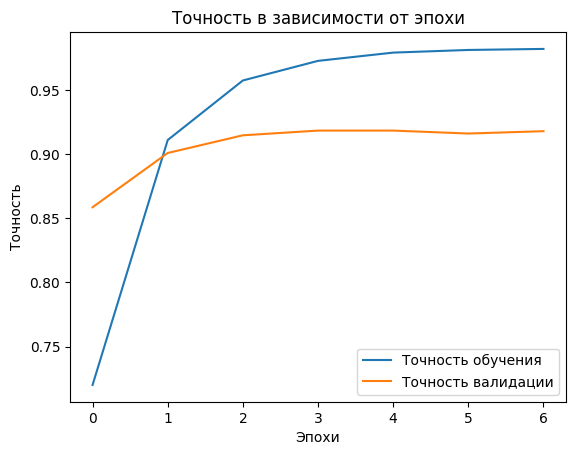

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Точность обучения')
plt.plot(val_accuracy, label='Точность валидации')
plt.title('Точность в зависимости от эпохи')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

Проверим пересечение:

In [ ]:
common_texts = set(train_df['text']).intersection(set(test_df['text']))
print(f"Общее количество пересечений текстов: {len(common_texts)}")

Общее количество пересечений текстов: 68


Совпадение токенов:

In [ ]:
train_vocab = set(' '.join(train_df['text']).split())
test_vocab = set(' '.join(test_df['text']).split())
overlap = len(train_vocab.intersection(test_vocab)) / len(test_vocab) * 100
print(f"Совпадение токенов между обучением и тестом: {overlap:.2f}%")

Совпадение токенов между обучением и тестом: 43.70%


Вывод самой модели:

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 196, 64)             │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,096,389 (11.81 MB)

 Trainable params: 1,032,129 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,064,260 (7.87 MB)